# Import Stuff

In [1]:
from sklearn.neural_network import MLPRegressor
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import pandas as pd
import numpy as np
import plotly.express as px
from shapely.geometry import Point, Polygon
import geopandas as gpd
import matplotlib.pyplot as plt


## Constants Definitions

In [2]:
rssPath = "../outputs"
rawdataPath = "../data"
gasMLHeader = ["valeur brute", "Latitude", "Longitude"]
gasNames = ["NO2", "O3", "PM2.5", "PM10", "SO2"]

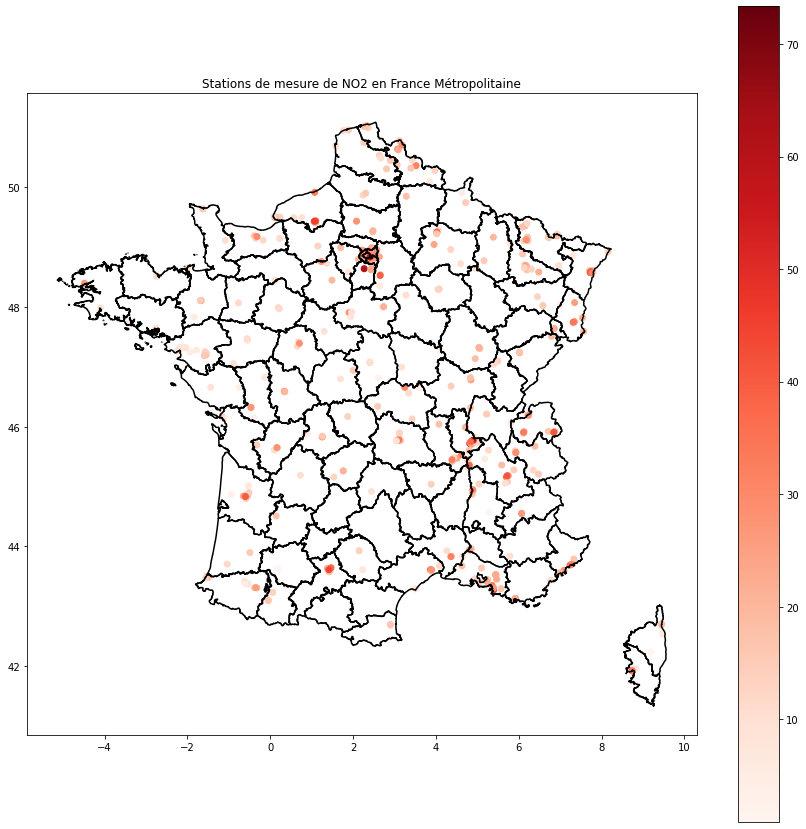

In [17]:
#Load each databas
datano2 = pd.read_csv(rssPath + "/NO2.csv", delimiter=";", header=0)
datao3 = pd.read_csv(rssPath + "/O3.csv", delimiter=";", header=0)
datapm25 = pd.read_csv(rssPath + "/PM2.5.csv", delimiter=";", header=0)
datapm10 = pd.read_csv(rssPath + "/PM10.csv", delimiter=";", header=0)
dataso2 = pd.read_csv(rssPath + "/SO2.csv", delimiter=";", header=0)

disease = pd.read_csv(rssPath + "/disease.csv", delimiter=";", header=0,
       dtype={'Insuffisance respiratoire chronique grave (ALD14)' : int})

franceData = gpd.read_file(rawdataPath + "/contour-des-departements.geojson")

#Insert the disease values directly in the France DataFrame
franceData['disease'] = disease['Insuffisance respiratoire chronique grave (ALD14)']


#See where the stations are
fig, ax = plt.subplots(figsize=(15,15))
p = plt.scatter(datano2['Longitude'], datano2['Latitude'], c=datano2['valeur brute'], cmap="Reds")
plt.colorbar(p)
franceData.boundary.plot(color="black", ax=ax)
plt.title('Stations de mesure de NO2 en France Métropolitaine')
plt.show()

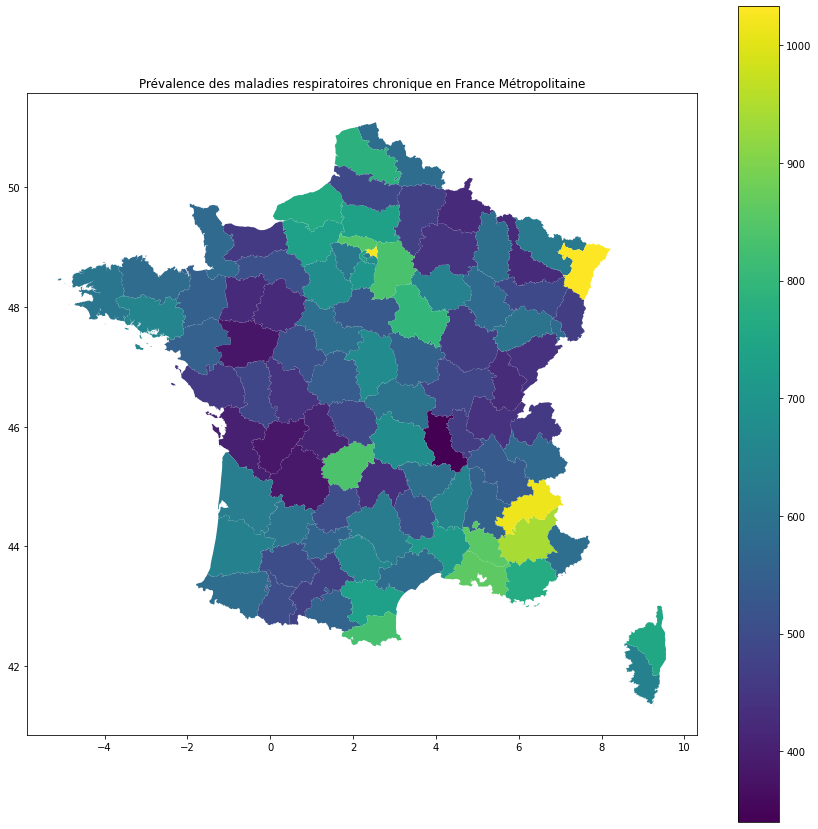

In [18]:
fig, ax = plt.subplots(figsize=(15,15))
franceData.plot(column='disease', ax=ax, legend=True)
plt.title('Prévalence des maladies respiratoires chronique en France Métropolitaine')
plt.show()

# Preprocessing
## Defining preprocessing functions

In [4]:
# Convert the DataFrame into a GeoDataFrame
def to_gdp(pdf) :
    lat = pdf['Latitude'].to_list()
    long = pdf['Longitude'].to_list()
    points = [Point(long[k], lat[k]) for k in range(len(lat))]
    pdf['geometry'] = points
    return gpd.GeoDataFrame(pdf, crs='EPSG:4326')

def find_stations_in_dep(department, stations) :
    containedPoints = []
    for ind, poi in stations.iterrows() :
        a = department.geometry.contains(poi.geometry)
        if a :
            containedPoints.append(poi)
    return containedPoints

def find_three_closest(department, stations) :
    distances = []
    middle = department.geometry.centroid
    for ind, poi in stations.iterrows() :
        a = middle.distance(poi.geometry)
        distances.append(a)
    result = []
    d = np.array(distances)
    for i in range(3) :
        close = np.argmin(d)
        result.append(stations.loc[close])
        d[close] = 1000
    return result

# If there are stations in a given department, the average is computed.
# Else, an average of the three closest stations is given
# There isn't enough data 
def affect_gas(france, stations, gasName) :
    score = []
    for ind, dep in france.iterrows() :
        indep = find_stations_in_dep(dep, stations)
        if (len(indep) == 0) :
            indep = find_three_closest(dep, stations)
        indep = pd.DataFrame(indep).copy()
        score.append(indep['valeur brute'].mean())
    france[gasName] = score


## Preprocess the dataframes and load them into France

/Users/aymericschneider/opt/anaconda3/lib/python3.8/site-packages/pandas/core/dtypes/cast.py:118: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)
/Users/aymericschneider/opt/anaconda3/lib/python3.8/site-packages/pandas/core/dtypes/cast.py:118: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)
/Users/aymericschneider/opt/anaconda3/lib/python3.8/site-packages/pandas/core/dtypes/cast.py:118: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)
/Users/aymericschneider/opt/anaconda3/lib/python3.8/site-packages/pandas/core/dtypes/cast.p

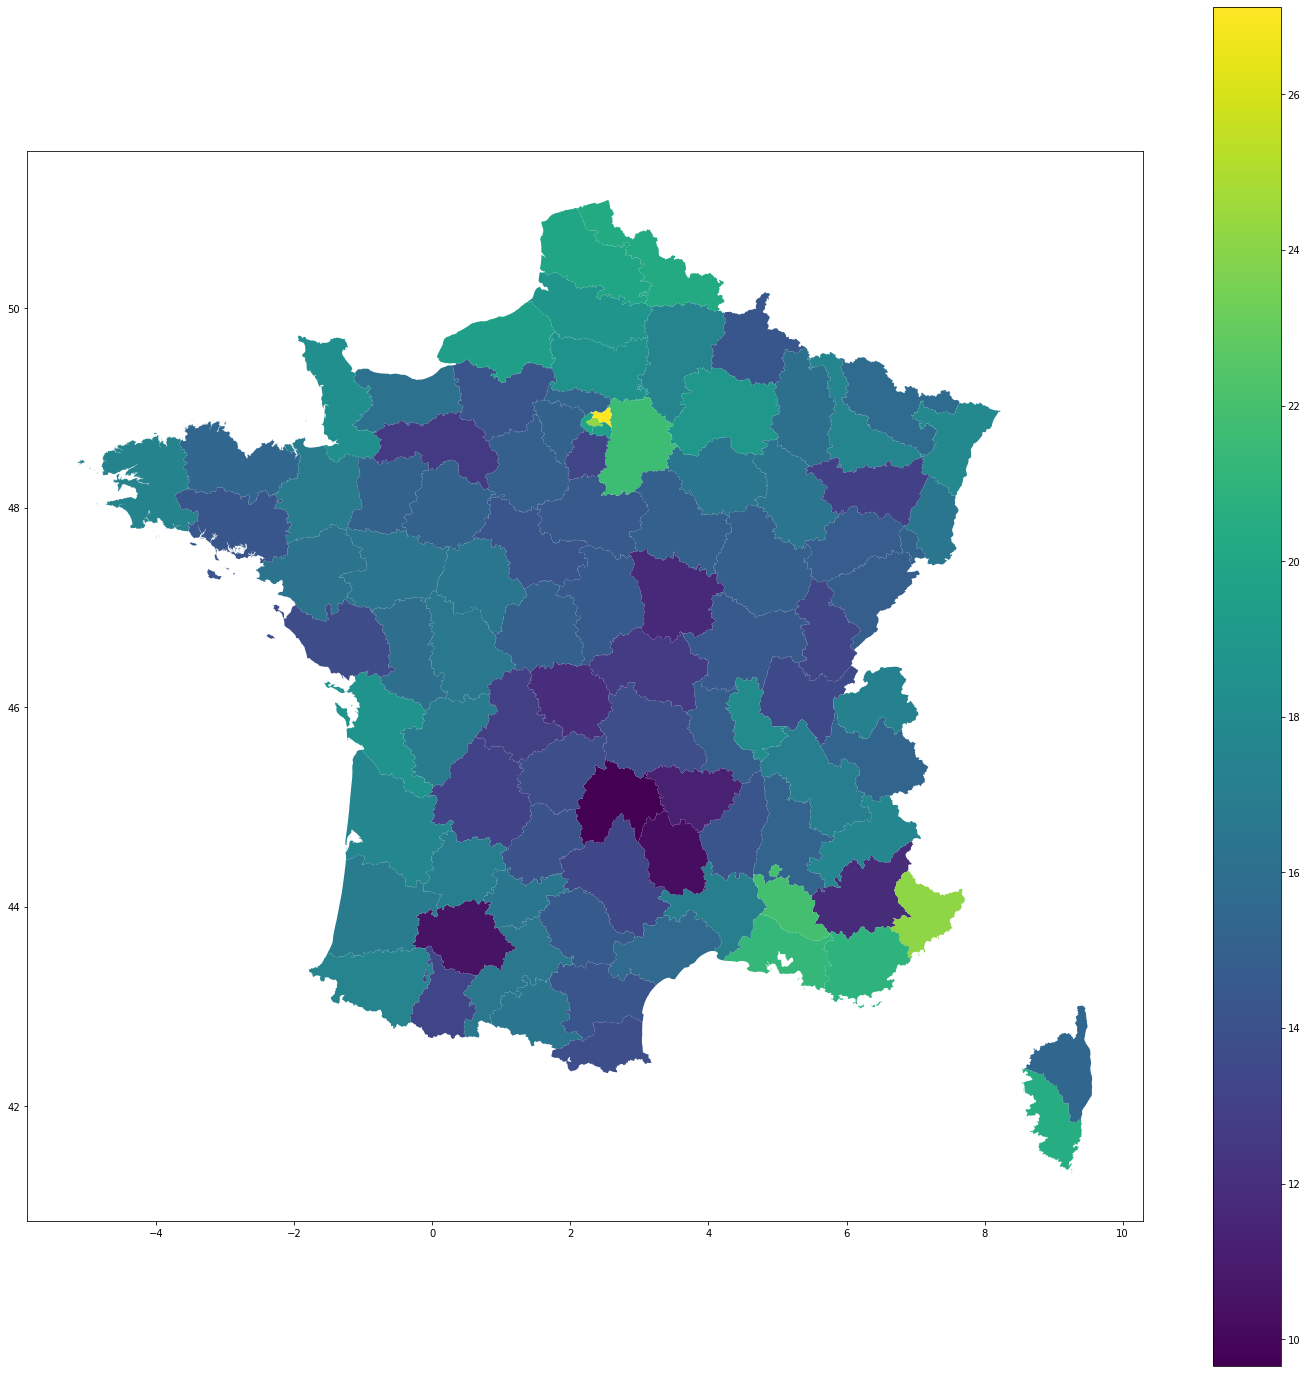

In [30]:
no2gdp = to_gdp(datano2)
o3gdp = to_gdp(datao3)
pm25gdp = to_gdp(datapm25)
pm10gdp = to_gdp(datapm10)
so2gdp = to_gdp(dataso2)


affect_gas(franceData, no2gdp, 'NO2')
affect_gas(franceData, o3gdp, 'O3')
affect_gas(franceData, pm25gdp, 'PM2.5')
affect_gas(franceData, pm10gdp, 'PM10')
affect_gas(franceData, so2gdp, 'SO2')

# Because we live for these graphs
fig, ax = plt.subplots(figsize=(25,25))
franceData.plot(column='PM10', ax=ax, legend=True)
plt.show()

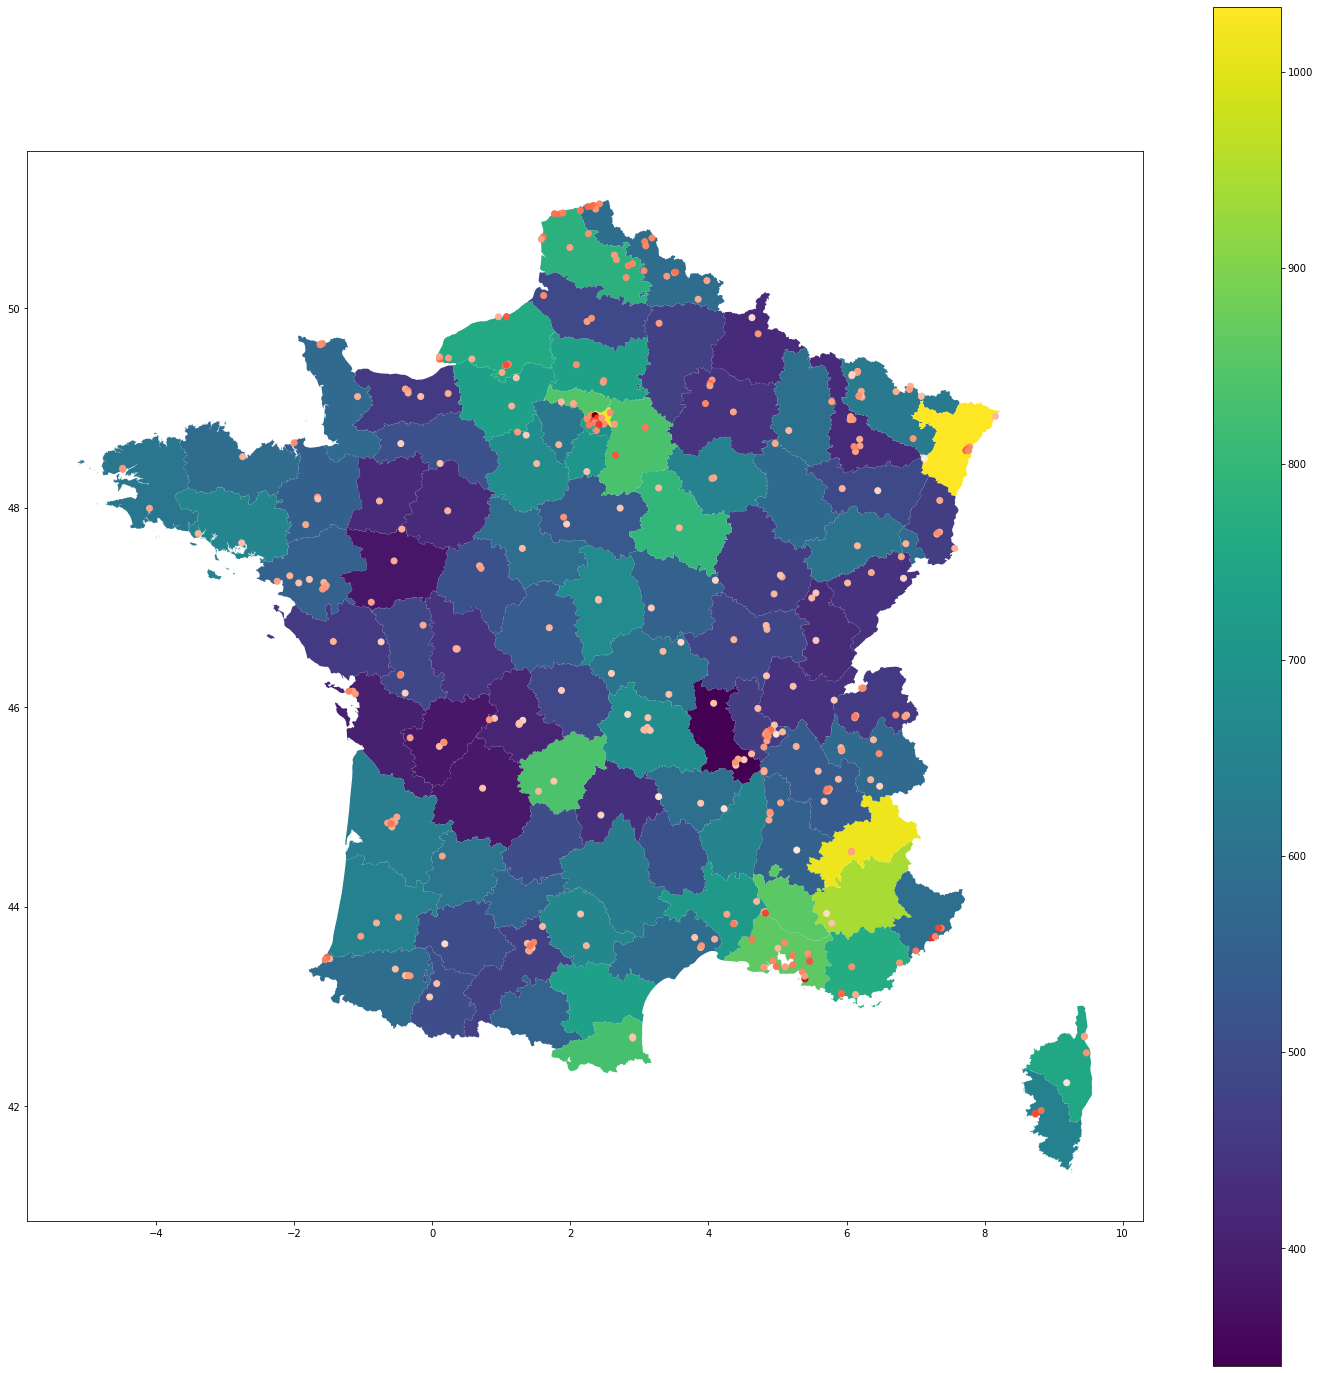

In [6]:
fig, ax = plt.subplots(figsize=(25,25))
franceData.plot(column='disease', ax=ax, legend=True)
plt.scatter(datapm10['Longitude'], datapm10['Latitude'], c=datapm10['valeur brute'], cmap="Reds")
plt.show()

# Visualizing results and interpretation

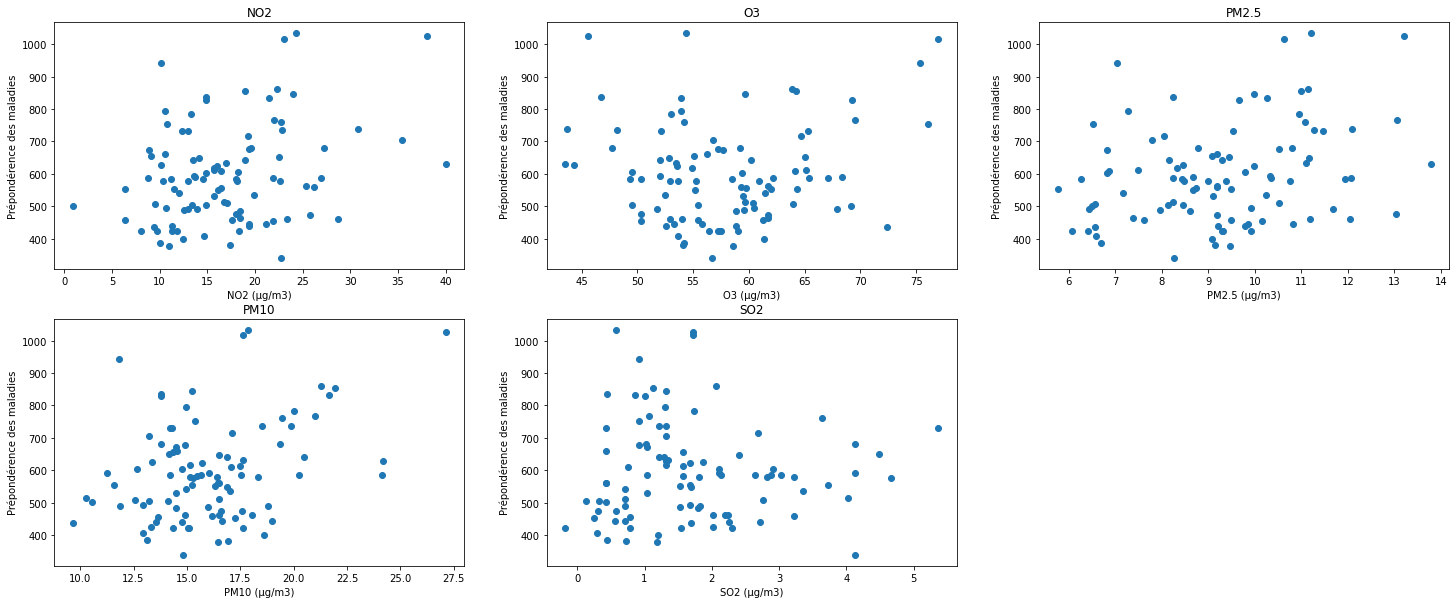

In [38]:
plt.close()
plt.figure(figsize=(25,10))
for i in range(1, 6) :
    plt.subplot(2, 3, i)
    plt.scatter(franceData[gasNames[i-1]], franceData['disease'])
    plt.xlabel(gasNames[i-1] + " (µg/m3)")
    plt.ylabel('Prépondérence des maladies')
    plt.title(gasNames[i-1])

plt.show()

## Correlation between each variables

In [42]:
# Doesn't look too good, but not really bad either
# Suggests we should look into PM10 and NO2
franceData.corr()

,disease,NO2,O3,PM2.5,PM10,SO2
disease,1.000000,0.295928,0.091996,0.289416,0.338127,-0.002247
NO2,0.295928,1.000000,-0.289428,0.587708,0.615162,0.088869
O3,0.091996,-0.289428,1.000000,-0.383225,-0.310568,-0.008858
PM2.5,0.289416,0.587708,-0.383225,1.000000,0.698226,0.082152
PM10,0.338127,0.615162,-0.310568,0.698226,1.000000,-0.069480
SO2,-0.002247,0.088869,-0.008858,0.082152,-0.069480,1.000000


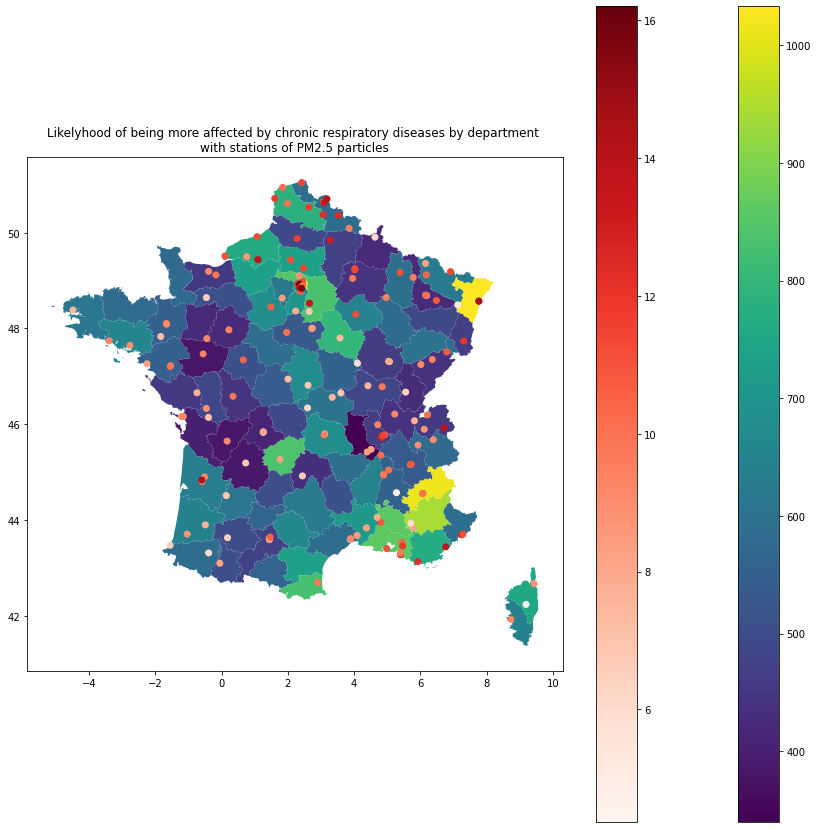

In [52]:
# PM10 and diseases

fig, ax = plt.subplots(figsize=(15,15))
franceData.plot(column='disease', ax=ax, legend=True)
p = plt.scatter(datapm25['Longitude'], datapm25['Latitude'], c=datapm25['valeur brute'], cmap="Reds")
plt.colorbar(p)
plt.title('Likelyhood of being more affected by chronic respiratory diseases by department \nwith stations of PM2.5 particles')
plt.show()

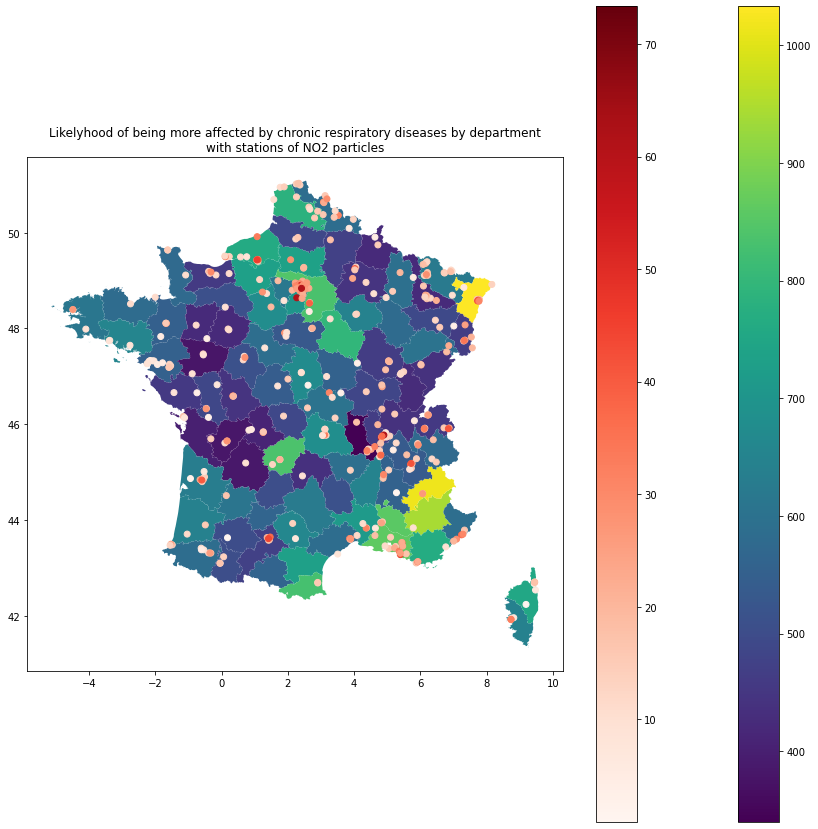

In [51]:
# NO2 and diseases

fig, ax = plt.subplots(figsize=(15,15))
franceData.plot(column='disease', ax=ax, legend=True)
p = plt.scatter(datano2['Longitude'], datano2['Latitude'], c=datano2['valeur brute'], cmap="Reds")
plt.colorbar(p)
plt.title('Likelyhood of being more affected by chronic respiratory diseases by department\nwith stations of NO2 particles')

plt.show()

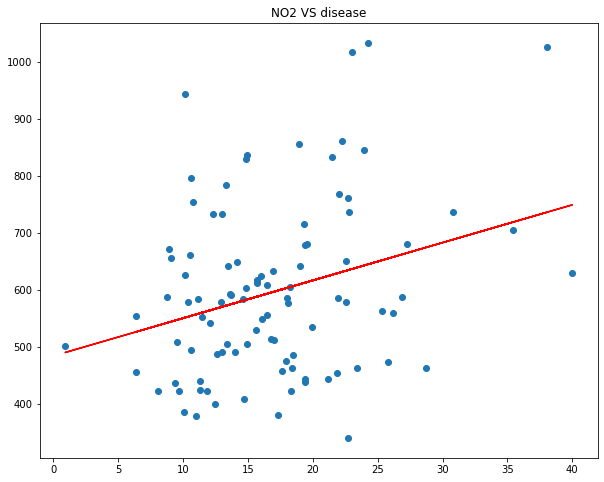

In [70]:
# Visualize the particles regression
model = LinearRegression()
X = franceData[['NO2']]
Y = franceData['disease']
model.fit(X, Y)
plt.figure(figsize=(10,8))
plt.scatter(X, Y)
plt.plot(X, model.predict(X), color='red')
plt.title("NO2 VS disease")
plt.show()

# JUNK

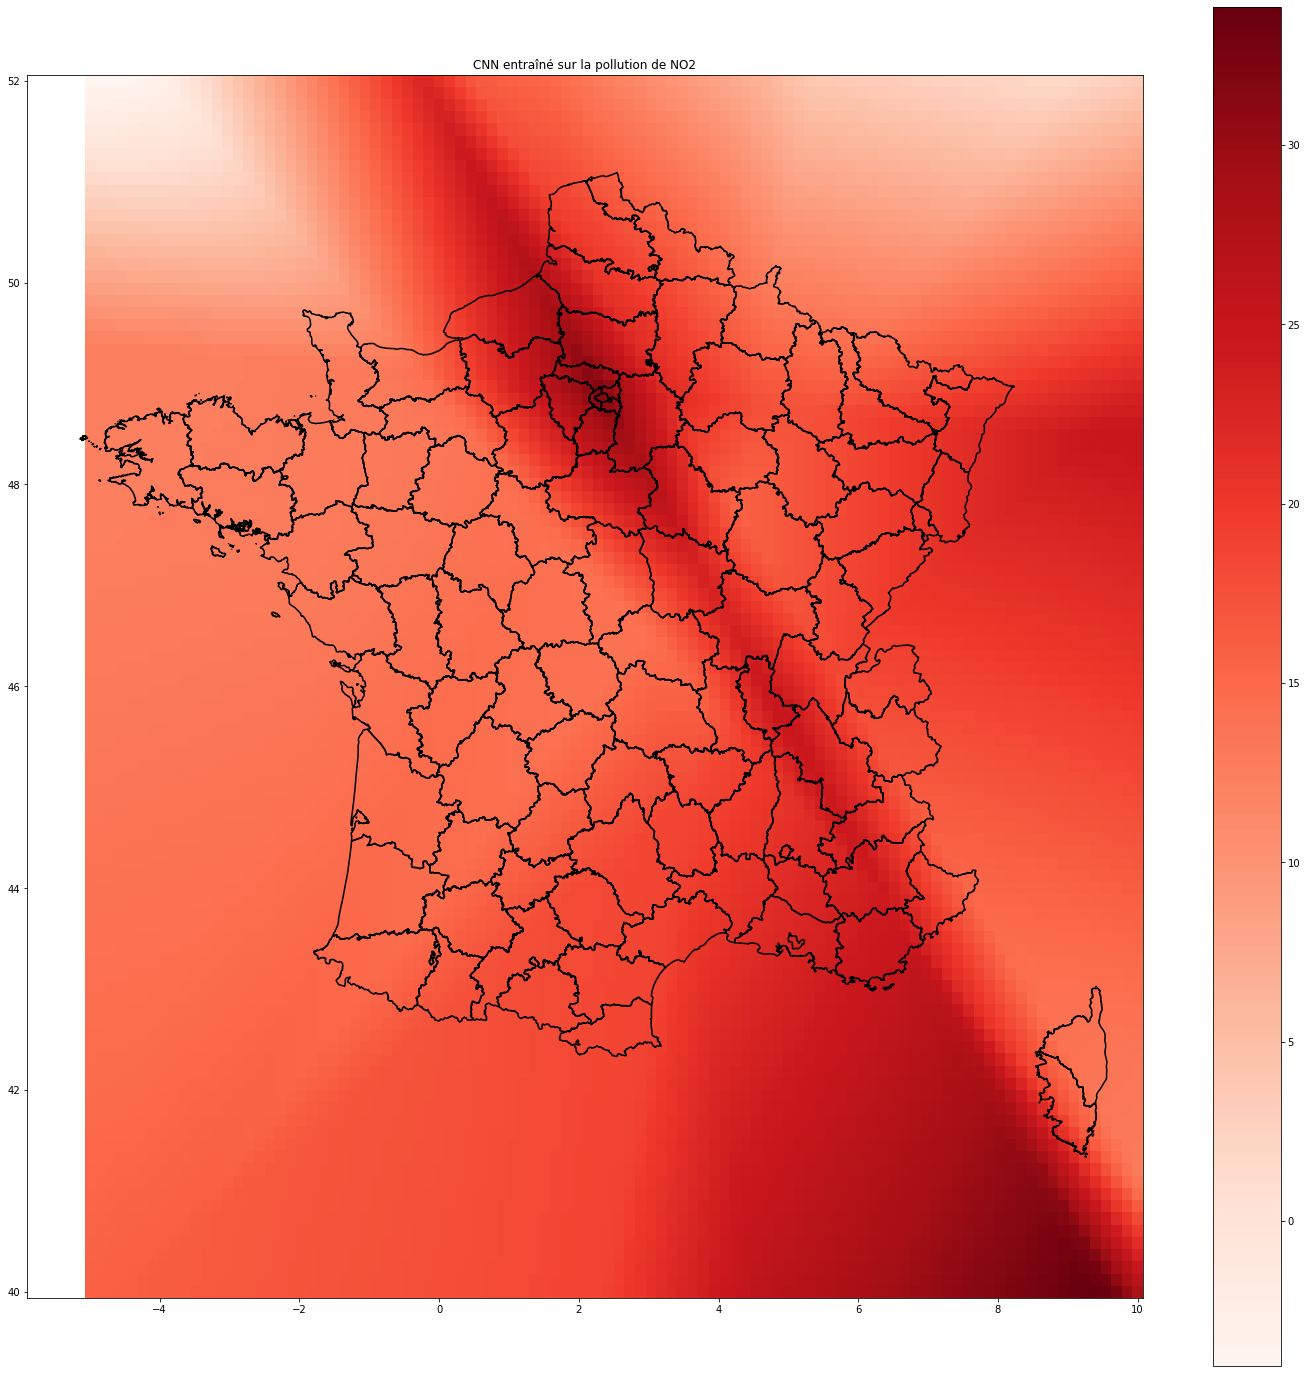

In [23]:
X_train = datano2[gasMLHeader[1:]].to_numpy()
Y_train = datano2[gasMLHeader[0]].to_numpy()

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)

classif = MLPRegressor(solver='sgd', hidden_layer_sizes=(100), activation='relu', max_iter=5000)

classif.fit(X_train, Y_train)

Xlat = np.linspace(40,52, num=100)
Xlong = np.linspace(-5, 10, num=100)


mesh = np.array(np.meshgrid(Xlat, Xlong))
pred = mesh.T.reshape(-1, 2)




pred = scaler.transform(pred)

Z = classif.predict(pred)
Z = Z.reshape(100, 100)

xv, yv = np.meshgrid(Xlong, Xlat)

plt.close()

fig, ax = plt.subplots(figsize=(25,25))

c = plt.pcolormesh(xv, yv, Z, cmap="Reds")
plt.colorbar(c)

franceData.boundary.plot(color="black", ax=ax)
plt.title('CNN entraîné sur la pollution de NO2')
plt.show()



In [13]:
print(mesh.shape)
print(mesh[0:5])


# print(pred)
print(Z.shape)

(2, 100, 100)
[[[40.         40.12121212 40.24242424 ... 51.75757576 51.87878788
   52.        ]
  [40.         40.12121212 40.24242424 ... 51.75757576 51.87878788
   52.        ]
  [40.         40.12121212 40.24242424 ... 51.75757576 51.87878788
   52.        ]
  ...
  [40.         40.12121212 40.24242424 ... 51.75757576 51.87878788
   52.        ]
  [40.         40.12121212 40.24242424 ... 51.75757576 51.87878788
   52.        ]
  [40.         40.12121212 40.24242424 ... 51.75757576 51.87878788
   52.        ]]

 [[-5.         -5.         -5.         ... -5.         -5.
   -5.        ]
  [-4.84848485 -4.84848485 -4.84848485 ... -4.84848485 -4.84848485
   -4.84848485]
  [-4.6969697  -4.6969697  -4.6969697  ... -4.6969697  -4.6969697
   -4.6969697 ]
  ...
  [ 9.6969697   9.6969697   9.6969697  ...  9.6969697   9.6969697
    9.6969697 ]
  [ 9.84848485  9.84848485  9.84848485 ...  9.84848485  9.84848485
    9.84848485]
  [10.         10.         10.         ... 10.         10.
   10.    

In [34]:
print(franceData)

   code                      nom  \
0    01                      Ain   
1    02                    Aisne   
2    03                   Allier   
3    04  Alpes-de-Haute-Provence   
4    05             Hautes-Alpes   
..  ...                      ...   
91   91                  Essonne   
92   92           Hauts-de-Seine   
93   93        Seine-Saint-Denis   
94   94             Val-de-Marne   
95   95               Val-d'Oise   

                                             geometry  disease        NO2  \
0   POLYGON ((4.78021 46.17668, 4.78024 46.18905, ...      440  11.309661   
1   POLYGON ((3.17296 50.01131, 3.17382 50.01186, ...      475  17.966328   
2   POLYGON ((3.03207 46.79491, 3.03424 46.79080, ...      603  14.849769   
3   POLYGON ((5.67604 44.19143, 5.67817 44.19051, ...      943  10.177062   
4   POLYGON ((6.26057 45.12685, 6.26417 45.12641, ...     1016  22.992953   
..                                                ...      ...        ...   
91  POLYGON ((2.22656 48.776